### Part 1: Approach

I needed to seek out a resource for a search algorithm, which I have listed below. Tried repurposing my Djikstra's algo from last year (day 15) but something was off)

Below is an overview of how the search works:

#### Preparing Data:
- The data should be stored as a graph, which I have done by using a dictionary:
    - each key represents a node, each value represents an adjacent node
    - ~~also important: I moved away from using coordinates and instead calculated an integer value to represent each coordinate by taking `row coord + col coord * num_cols`. This equation ensures a clean mapping from coordinate to integer, and each integer can now represent a node in full.~~
    - ~~Finally, I made the end node `999_999`, this mattered more in early experimentation and actually shouldn't matter now.~~
    
    
#### Path Search: BFS

- Breadth-first search is going to start at our root (`starting coordinate`) and explore all other "root level" (which does not exist for this problem)
    - We also maintain a previous nodes list so we don't backtrack

**Now we move to our adjacent nodes which is in our while loop**

- While loop logic:
    - Check if the path_index is smaller than length of path list:
        if not then we actually had no new nodes to tack on (this occurs under the `add new paths` section) which indicates we have run out of search space. This will yield an automatic `return empty list` indicating it is not possible to traverse (example below)
        
- Assume we are now in the while loop, we have the following process:
    - First we get out `current_path`, initially it will just have our `start` but over time we will add to this
    - We then find the `last_node` we visited in `current_path`, this is used to find all adjacent nodes 
    - If our `end node (node2)` appears in our adjacent nodes then we stop -> we have solved the problem. 
        - This threw me off initially but this is fine to do since we have already checked each of the other depths. At this point we are dealing with similarly-lengthed listed and adjacent nodes, so returning here would indicate our shortest list (not returning here would mean we keep searching down a longer list)
    - If not, then we iterate over each node (this is the `breadth` component, we aren't just digging deep, rather we span a wide net around options our node touches
        - With each next node we confirm we haven't visited it (if we have then we pass to the next node)
        - We make a copy of the currenr_path & append this node -> call it `new_path`
        - `new_path` is now added to our path_list (meaning `len(path_list)` increments by 1. 
            - This also means when we finish our loop and increment our `path_index` by 1 that we are going to eventually return to this incomplete path. We will find this most recent add, review which neighbors aren't in our `previous_nodes` list and then continue our search!
        - we also add this node to our `previous_nodes` list to avoid backtracking
            
Walking through this was very helpful, this is a pretty nice algorithm.

In [1]:
# source: https://onestepcode.com/graph-shortest-path-python/
def shortest_path(graph, node1, node2, debug = False):
    path_list = [[node1]]
    path_index = 0
    # To keep track of previously visited nodes
    previous_nodes = {node1}
    if node1 == node2:
        return path_list[0]
        
    while path_index < len(path_list):
        current_path = path_list[path_index]
        last_node = current_path[-1]
        next_nodes = graph[last_node]
        # Search goal node
        if node2 in next_nodes:
            current_path.append(node2)
            return current_path
        # Add new paths
        for next_node in next_nodes:
            if not next_node in previous_nodes:
                new_path = current_path[:]
                new_path.append(next_node)
                path_list.append(new_path)
                # To avoid backtracking
                previous_nodes.add(next_node)
                if debug:
                    print(new_path)
        # Continue to next path in list
        path_index += 1
    # No path is found
    return []

# find path from 
graph = {}
graph[1] = {2, 5}
graph[2] = {1, 3, 5}
graph[3] = {2, 4}
graph[4] = {3, 5, 6}
graph[5] = {1, 2, 4}
graph[6] = {4}
graph[7] = {}

# example with connection
# Could go 6 -> 4 -> 5 -> 1
# But also could go: 6 -> 4 -> 3 -> 2 -> 1 (which is longer)
assert(shortest_path(graph, 6, 1, True) == [6,4,5,1])
print("-----")
# example where 7 has no connections, so we yield an empty list
assert(shortest_path(graph, 3, 7, True) == [])

[6, 4]
[6, 4, 3]
[6, 4, 5]
[6, 4, 3, 2]
-----
[3, 2]
[3, 4]
[3, 2, 1]
[3, 2, 5]
[3, 4, 6]


In [2]:
import numpy as np
with open('data/day12_sample.txt') as fh:
    data = [line.strip() for line in fh.readlines()]

# convert to matrix, use ord for easier elevation checks
m = np.asarray([x for y in data for x in y])
m.shape = (len(data), len(data[0]))

# find start, end coords
start = (np.where(m == 'S')[0][0], np.where(m == 'S')[1][0])
end = (np.where(m == 'E')[0][0], np.where(m == 'E')[1][0])
print(start)
print(end)

# convert S & E to elevation values now that we have coords
m[start] = 'a'
m[end] = 'z'

# convert all to ORD
ord_vec = np.vectorize(ord)
final_m = ord_vec(m)
final_m

(0, 0)
(2, 5)


array([[ 97,  97,  98, 113, 112, 111, 110, 109],
       [ 97,  98,  99, 114, 121, 120, 120, 108],
       [ 97,  99,  99, 115, 122, 122, 120, 107],
       [ 97,  99,  99, 116, 117, 118, 119, 106],
       [ 97,  98, 100, 101, 102, 103, 104, 105]])

In [3]:
def getNeighbors(matrix, i, j):
    """Return neighboring coordinates within boundary of matrix"""
    r_max = matrix.shape[0]
    c_max = matrix.shape[1]
    
    # only consider upwards
    coord_list = [(i, j+1), (i, j-1), (i-1,j), (i+1,j)]
    final_list = []

    for coord in coord_list:
        i = coord[0]
        j = coord[1]
        if (i >= 0 and i < r_max) and (j >= 0 and j < c_max):
            final_list.append(coord)
    return final_list

def eligibleMovement(matrix, coord):
    """Return eligible movement considering elevation constraints"""
    # find current position & value
    i = coord[0]
    j = coord[1]
    cur_val = matrix[coord]
    boundary_options = getNeighbors(matrix, i, j)
    
    # reduce options to those with values <= cur_val + 1
    # Note: There is no lower bound constraint
    final_set = []
    for coords in boundary_options:
        if matrix[coords] <= cur_val + 1:
            final_set.append(coords)
    
    return final_set

# Testing:
# At the start we only have 2 options, all with same elevation
out = eligibleMovement(final_m , (0,0))
assert(out == [(0,1), (1, 0)])

# 4 option example: (2,1) -> c surrounded bt a b (-1), c(0), c(0), and a(-2) -> all legal
out = eligibleMovement(final_m , (2,1))
assert(out == [(2, 2), (2,0), (1,1), (3,1)])

# This is next to a z so we should not be able to move to (2,3)
out = eligibleMovement(final_m , (2,2))
assert(out == [(2, 1), (1, 2), (3, 2)])

In [4]:
# now we can get all eligible connections for each vertex
elig_dict = {}
for col in range(final_m.shape[1]):
    for row in range(final_m.shape[0]): 
        elig_dict[(row,col)] = eligibleMovement(final_m, (row,col))
        
elig_dict

{(0, 0): [(0, 1), (1, 0)],
 (1, 0): [(1, 1), (0, 0), (2, 0)],
 (2, 0): [(1, 0), (3, 0)],
 (3, 0): [(2, 0), (4, 0)],
 (4, 0): [(4, 1), (3, 0)],
 (0, 1): [(0, 2), (0, 0), (1, 1)],
 (1, 1): [(1, 2), (1, 0), (0, 1), (2, 1)],
 (2, 1): [(2, 2), (2, 0), (1, 1), (3, 1)],
 (3, 1): [(3, 2), (3, 0), (2, 1), (4, 1)],
 (4, 1): [(4, 0), (3, 1)],
 (0, 2): [(0, 1), (1, 2)],
 (1, 2): [(1, 1), (0, 2), (2, 2)],
 (2, 2): [(2, 1), (1, 2), (3, 2)],
 (3, 2): [(3, 1), (2, 2), (4, 2)],
 (4, 2): [(4, 3), (4, 1), (3, 2)],
 (0, 3): [(0, 4), (0, 2), (1, 3)],
 (1, 3): [(1, 2), (0, 3), (2, 3)],
 (2, 3): [(2, 2), (1, 3), (3, 3)],
 (3, 3): [(3, 4), (3, 2), (2, 3), (4, 3)],
 (4, 3): [(4, 4), (4, 2)],
 (0, 4): [(0, 5), (0, 3)],
 (1, 4): [(1, 5), (1, 3), (0, 4), (2, 4)],
 (2, 4): [(2, 5), (2, 3), (1, 4), (3, 4)],
 (3, 4): [(3, 5), (3, 3), (4, 4)],
 (4, 4): [(4, 5), (4, 3)],
 (0, 5): [(0, 6), (0, 4)],
 (1, 5): [(1, 6), (1, 4), (0, 5)],
 (2, 5): [(2, 6), (2, 4), (1, 5), (3, 5)],
 (3, 5): [(3, 6), (3, 4), (4, 5)],
 (4, 5): 

In [5]:
# convert each coordinate to be a single, distinct value -> easier to handle in terms of node
# row = row
# col = col + col * 5 - 1
# so (0,0) -> 0
# so (0, 1) -> 5

new_dict = {}
for k,v in elig_dict.items():
    if k == end:
        print("Make end biggest")
        new_k = 999_999
    else:
        new_k = k[0] + k[1] + k[1] * 5
    #print(k, new_k)
    
    # new vs:
    new_vs = [k[0] + k[1] + k[1] * 5 if k != end else 999_999 for k in v]
    #print(v, new_vs)

    new_dict[new_k] = new_vs

Make end biggest


In [6]:
graph = {}
for k, vals in elig_dict.items():
    #print(k, vals)
    graph[k] = {v for v in vals}
    
short_path = shortest_path(graph, start, end)
print(len(short_path) - 1)

31


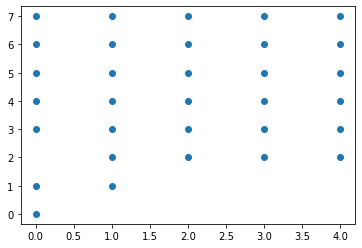

In [7]:
from matplotlib import pyplot as plt

data = np.array(short_path)
x, y = data.T
plt.scatter(x,y)
plt.show();

In [8]:
import numpy as np
with open('data/day12.txt') as fh:
    data = [line.strip() for line in fh.readlines()]

# convert to matrix, use ord for easier elevation checks
m = np.asarray([x for y in data for x in y])
m.shape = (len(data), len(data[0]))

# find start, end coords
start = (np.where(m == 'S')[0][0], np.where(m == 'S')[1][0])
end = (np.where(m == 'E')[0][0], np.where(m == 'E')[1][0])
print(start)
print(end)

# convert S & E to elevation values now that we have coords
m[start] = 'a'
m[end] = 'z'

# convert all to ORD
ord_vec = np.vectorize(ord)
final_m = ord_vec(m)
final_m

(20, 0)
(20, 107)


array([[97, 98, 99, ..., 97, 97, 97],
       [97, 98, 99, ..., 97, 97, 97],
       [97, 98, 99, ..., 97, 97, 97],
       ...,
       [97, 98, 99, ..., 97, 97, 97],
       [97, 98, 99, ..., 97, 97, 97],
       [97, 98, 99, ..., 97, 97, 97]])

In [9]:
# now we can get all eligible connections for each vertex
elig_dict = {}
for col in range(final_m.shape[1]):
    for row in range(final_m.shape[0]): 
        elig_dict[(row,col)] = eligibleMovement(final_m, (row,col))

In [10]:
graph = {}
for k, vals in elig_dict.items():
    #print(k, vals)
    graph[k] = {v for v in vals}

short_path = shortest_path(graph, start, end)
print(len(short_path) - 1)

449


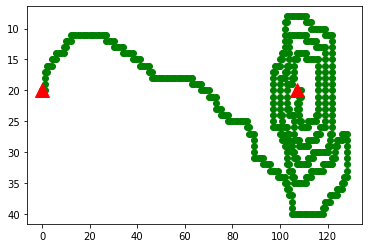

In [11]:
plt.gca().invert_yaxis() # numpy
data = np.array(short_path)
y, x = data.T
plt.plot(start[1], start[0], c = 'red', marker='^', markersize=14)
plt.plot(end[1], end[0], c = 'red', marker='^', markersize=14)
plt.scatter(x,y, c = 'green')
plt.show();

### Part 2: Find All Candidate Starting Points

Seemed suspiciously easy.

In [12]:
min_v = 451
for i, j in np.argwhere(m == 'a'):
    short_path = shortest_path(graph, (i,j), end)
    
    if (len(short_path) - 1 < min_v) and (len(short_path) - 1 > 0):
        print(len(short_path) - 1)
        min_v = (len(short_path) - 1)
        
print(f"Final Answer: {min_v}")

450
449
448
447
446
445
444
443
Final Answer: 443
